# SOC-Grade Deep Learning Anomaly Detection

## Executive Summary

This notebook presents a comprehensive analysis of the **Deep Learning-based Anomaly Detection System** for Security Operations Center (SOC) log monitoring. The system implements a complete pipeline from raw log ingestion to automated alert generation, using Deep Learning (LSTM-based DeepLog architecture) to detect anomalous log sequences.

## Pipeline Overview

```
Raw Logs → Parse → Sequence → Model → Score → Alert
```

**Pipeline Phases:**
1. **Log** - Raw log ingestion and preprocessing
2. **Parse** - Log template extraction using Drain3
3. **Sequence** - Temporal sequence construction with sliding windows
4. **Model** - Deep Learning model (LSTM) training and inference
5. **Score** - Anomaly score computation using negative log-likelihood
6. **Alert** - Automated alert generation with severity classification

---

In [1]:
# Import libraries
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from collections import Counter
import torch # type: ignore  # noqa: F401
import seaborn as sns  # type: ignore  # noqa: F401
from scipy.stats import spearmanr

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('default')
        print("Using default matplotlib style")

%matplotlib inline

print(" Libraries imported successfully")
print(f" Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

 Libraries imported successfully
 Report Generated: 2026-01-07 22:50:17


---

## Phase 1: Log Ingestion 

In this phase, we collect and preprocess raw log data from various sources (e.g., auth.log, system.log).

In [2]:
# Check log data availability
log_dir = Path("../data/raw")
parsed_file = Path("../data/parsed/parsed_data.json")
ingestion_file = Path("../ingestion/full_log.log")


# Check raw logs
if log_dir.exists():
    log_files = list(log_dir.glob("*.log"))
    print(f"\n Raw Log Files Found: {len(log_files)}")
    for log_file in log_files:
        size_mb = log_file.stat().st_size / (1024 * 1024)
        print(f"   - {log_file.name}: {size_mb:.2f} MB")
else:
    print(f"\n Raw log directory not found: {log_dir}")

# Check ingested logs
if ingestion_file.exists():
    size_mb = ingestion_file.stat().st_size / (1024 * 1024)
    with open(ingestion_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    print(f"\n Ingested Log File: {ingestion_file.name}")
    print(f"   - Total lines: {len(lines):,}")
    print(f"   - File size: {size_mb:.2f} MB")
    



 Raw log directory not found: ..\data\raw

 Ingested Log File: full_log.log
   - Total lines: 103,215
   - File size: 11.01 MB


---

## Phase 2: Parse 

In this phase, log entries are parsed using Drain3 to extract log templates, which helps to normalize and reduce data size.



 Parsed Data Statistics:
   - Total log entries: 103,215
   - Unique log templates: 28

 Top 5 Most Frequent Templates:
    1. Template ID  1: 97,130 occurrences (94.10%)
       Template: Accepted password for admin from <:IP:> port <:NUM:> ssh2...
    2. Template ID  8:  3,114 occurrences ( 3.02%)
       Template: Failed password for admin from <:IP:> port <:NUM:> ssh2...
    3. Template ID  5:    843 occurrences ( 0.82%)
       Template: Invalid user test from <:IP:>...
    4. Template ID  4:    435 occurrences ( 0.42%)
       Template: Did not receive identification string from <:IP:>...
    5. Template ID  7:    418 occurrences ( 0.40%)
       Template: User root not allowed because account is locked...


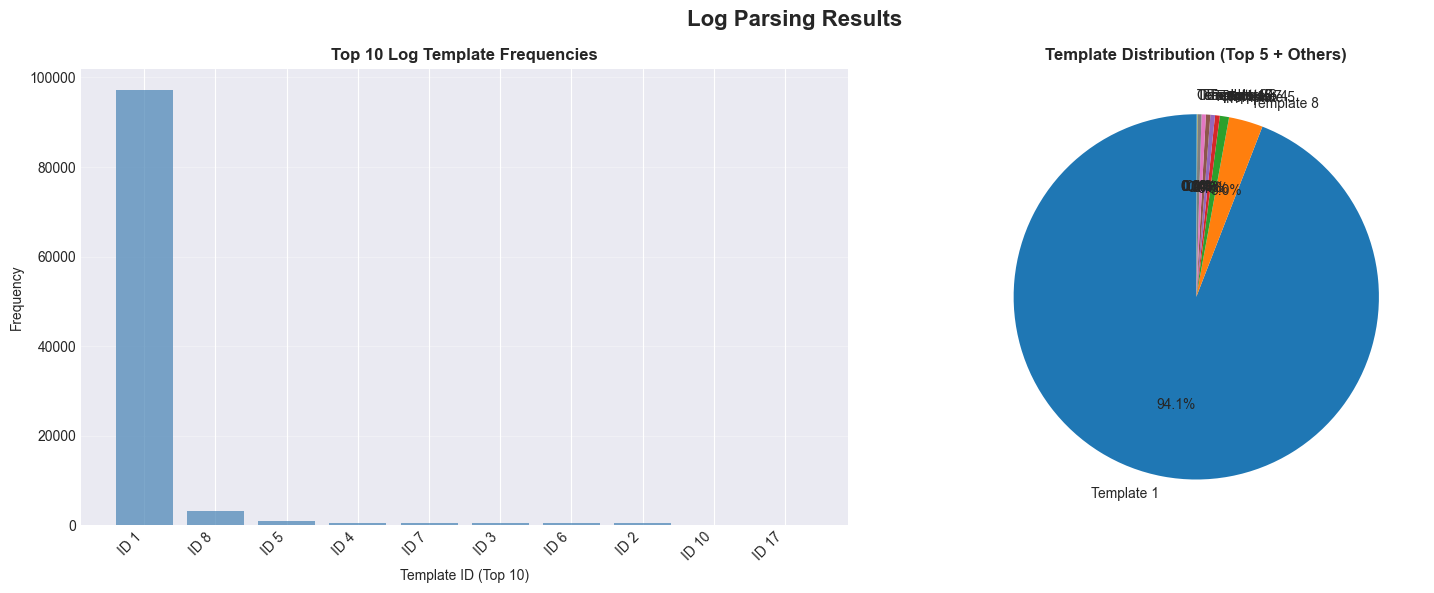


 Parsing completed successfully!
   - Compression ratio: 28 unique templates from 103,215 log entries
   - Average occurrences per template: 3686.2


In [3]:
# Analyze parsed data
parsed_file = Path("../data/parsed/parsed_data.json")

if parsed_file.exists():
    with open(parsed_file, 'r', encoding='utf-8') as f:
        parsed_data = json.load(f)
    
    print(f"\n Parsed Data Statistics:")
    print(f"   - Total log entries: {len(parsed_data):,}")
    
    # Analyze templates
    template_ids = [entry['template_id'] for entry in parsed_data]
    unique_templates = set(template_ids)
    print(f"   - Unique log templates: {len(unique_templates)}")
    
    # Template frequency
    template_counts = Counter(template_ids)
    print(f"\n Top 5 Most Frequent Templates:")
    for i, (template_id, count) in enumerate(template_counts.most_common(5), 1):
        template_text = next((e['template_text'] for e in parsed_data if e['template_id'] == template_id), "N/A")
        percentage = (count / len(parsed_data)) * 100
        print(f"   {i:2d}. Template ID {template_id:2d}: {count:6,} occurrences ({percentage:5.2f}%)")
        print(f"       Template: {template_text[:80]}...")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Template distribution
    top_10 = dict(template_counts.most_common(10))
    axes[0].bar(range(len(top_10)), list(top_10.values()), color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Template ID (Top 10)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Top 10 Log Template Frequencies', fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].set_xticks(range(len(top_10)))
    axes[0].set_xticklabels([f"ID {tid}" for tid in top_10.keys()], rotation=45, ha='right')

    # Template distribution pie chart (top 10)
    top_10 = dict(template_counts.most_common(10))
    other_count = len(parsed_data) - sum(top_10.values())
    pie_data = list(top_10.values()) + [other_count]
    pie_labels = [f"Template {tid}" for tid in top_10.keys()] + ["Others"]
    
    axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Template Distribution (Top 5 + Others)', fontweight='bold')
    
    plt.suptitle('Log Parsing Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n Parsing completed successfully!")
    print(f"   - Compression ratio: {len(unique_templates)} unique templates from {len(parsed_data):,} log entries")
    print(f"   - Average occurrences per template: {len(parsed_data) / len(unique_templates):.1f}")
else:
    print(f"\n  Parsed data file not found: {parsed_file}")
    print("   Run the parsing pipeline first.")




## Phase 3: Sequence 

In this phase, log templates are converted into temporal sequences with a sliding window so that the model can learn the patterns over time.



 Sequence Statistics:
   - Total sequences: 103,195
   - Unique event templates: 28

 Sequence Length Statistics:
   - Mean length: 20.00
   - Median length: 20.00
   - Min length: 20
   - Max length: 20
   - Std length: 0.00


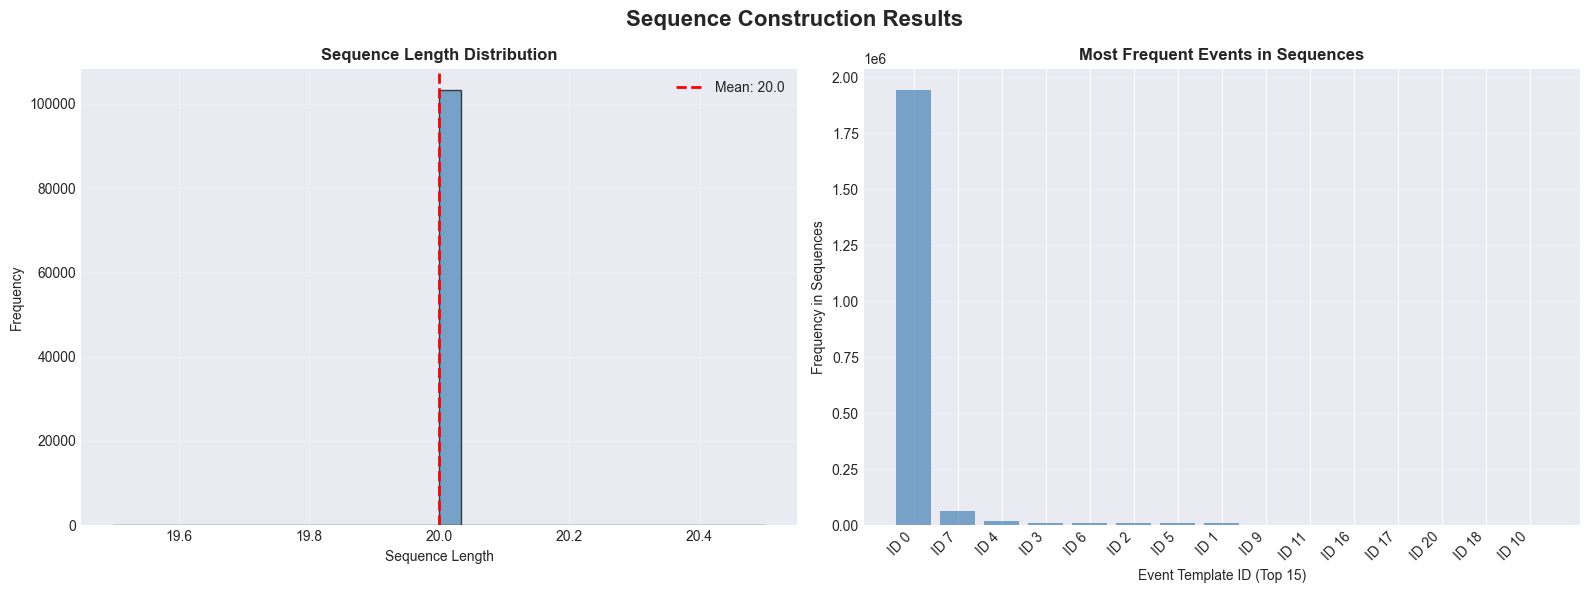


 Sample Sequences (first 3):
   Sequence 1: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]...
   Sequence 2: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]...
   Sequence 3: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]...

 Sequence construction completed successfully!
   - Total sliding window samples: 103,195


In [4]:
# Load and analyze sequences
sequences_path = Path("../data/sequences/sequences.pkl")
event_mapping_path = Path("../data/sequences/event_mapping.json")


if sequences_path.exists() and event_mapping_path.exists():
    with open(sequences_path, "rb") as f:
        sequences = pickle.load(f)
    
    with open(event_mapping_path, "r") as f:
        event_mapping = json.load(f)
    
    print(f"\n Sequence Statistics:")
    print(f"   - Total sequences: {len(sequences):,}")
    print(f"   - Unique event templates: {len(event_mapping['idx2event'])}")
    
    # Sequence length analysis
    seq_lengths = [len(seq) for seq in sequences]
    print(f"\n Sequence Length Statistics:")
    print(f"   - Mean length: {np.mean(seq_lengths):.2f}")
    print(f"   - Median length: {np.median(seq_lengths):.2f}")
    print(f"   - Min length: {min(seq_lengths)}")
    print(f"   - Max length: {max(seq_lengths)}")
    print(f"   - Std length: {np.std(seq_lengths):.2f}")
    
    # Visualize sequence statistics
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Sequence length distribution
    axes[0].hist(seq_lengths, bins=30, alpha=0.7, edgecolor='black', color='steelblue')
    axes[0].axvline(np.mean(seq_lengths), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(seq_lengths):.1f}')
    axes[0].set_xlabel('Sequence Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Sequence Length Distribution', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Event frequency in sequences
    all_events = []
    for seq in sequences:
        all_events.extend(seq)
    
    event_counts = Counter(all_events)
    top_events = dict(event_counts.most_common(15))
    
    axes[1].bar(range(len(top_events)), list(top_events.values()), color='steelblue', alpha=0.7)
    axes[1].set_xlabel('Event Template ID (Top 15)')
    axes[1].set_ylabel('Frequency in Sequences')
    axes[1].set_title('Most Frequent Events in Sequences', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_xticks(range(len(top_events)))
    axes[1].set_xticklabels([f"ID {eid}" for eid in top_events.keys()], rotation=45, ha='right')
    
    plt.suptitle('Sequence Construction Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show sample sequences
    print(f"\n Sample Sequences (first 3):")
    idx2event = event_mapping['idx2event']
    for i, seq in enumerate(sequences[:3], 1):
        print(f"   Sequence {i}: {seq[:10]}..." if len(seq) > 10 else f"   Sequence {i}: {seq}")
    
    print(f"\n Sequence construction completed successfully!")
    print(f"   - Total sliding window samples: {len(sequences):,}")
else:
    print(f"\n Sequence files not found.")
    print(f"   - Sequences: {sequences_path}")
    print(f"   - Mapping: {event_mapping_path}")
    print("   Run the sequence construction pipeline first.")


---

## Phase 4: Model 

In this phase, we train and evaluate the Deep Learning model (LSTM-based DeepLog) to learn normal patterns from log sequences.



  Model Configuration:
   - Architecture: DeepLog LSTM
   - Number of log templates: 28
   - Window size: 5
   - Embedding dimension: 16
   - Hidden size: 128
   - LSTM layers: 1

 Model Summary:

[ARCHITECTURE]
DeepLogLSTM(
  (embedding): Embedding(28, 16)
  (lstm): LSTM(16, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=28, bias=True)
)

[PARAMETERS]
  Total parameters      : 78,812
  Trainable parameters : 78,812
  Non-trainable         : 0

[MODEL SIZE]
  Estimated size       : 0.30 MB

[LAYER BREAKDOWN]
  embedding            : 448 parameters
  lstm                 : 74,752 parameters
  fc                   : 3,612 parameters

[FORWARD PASS TEST]
  Error: index out of range in self


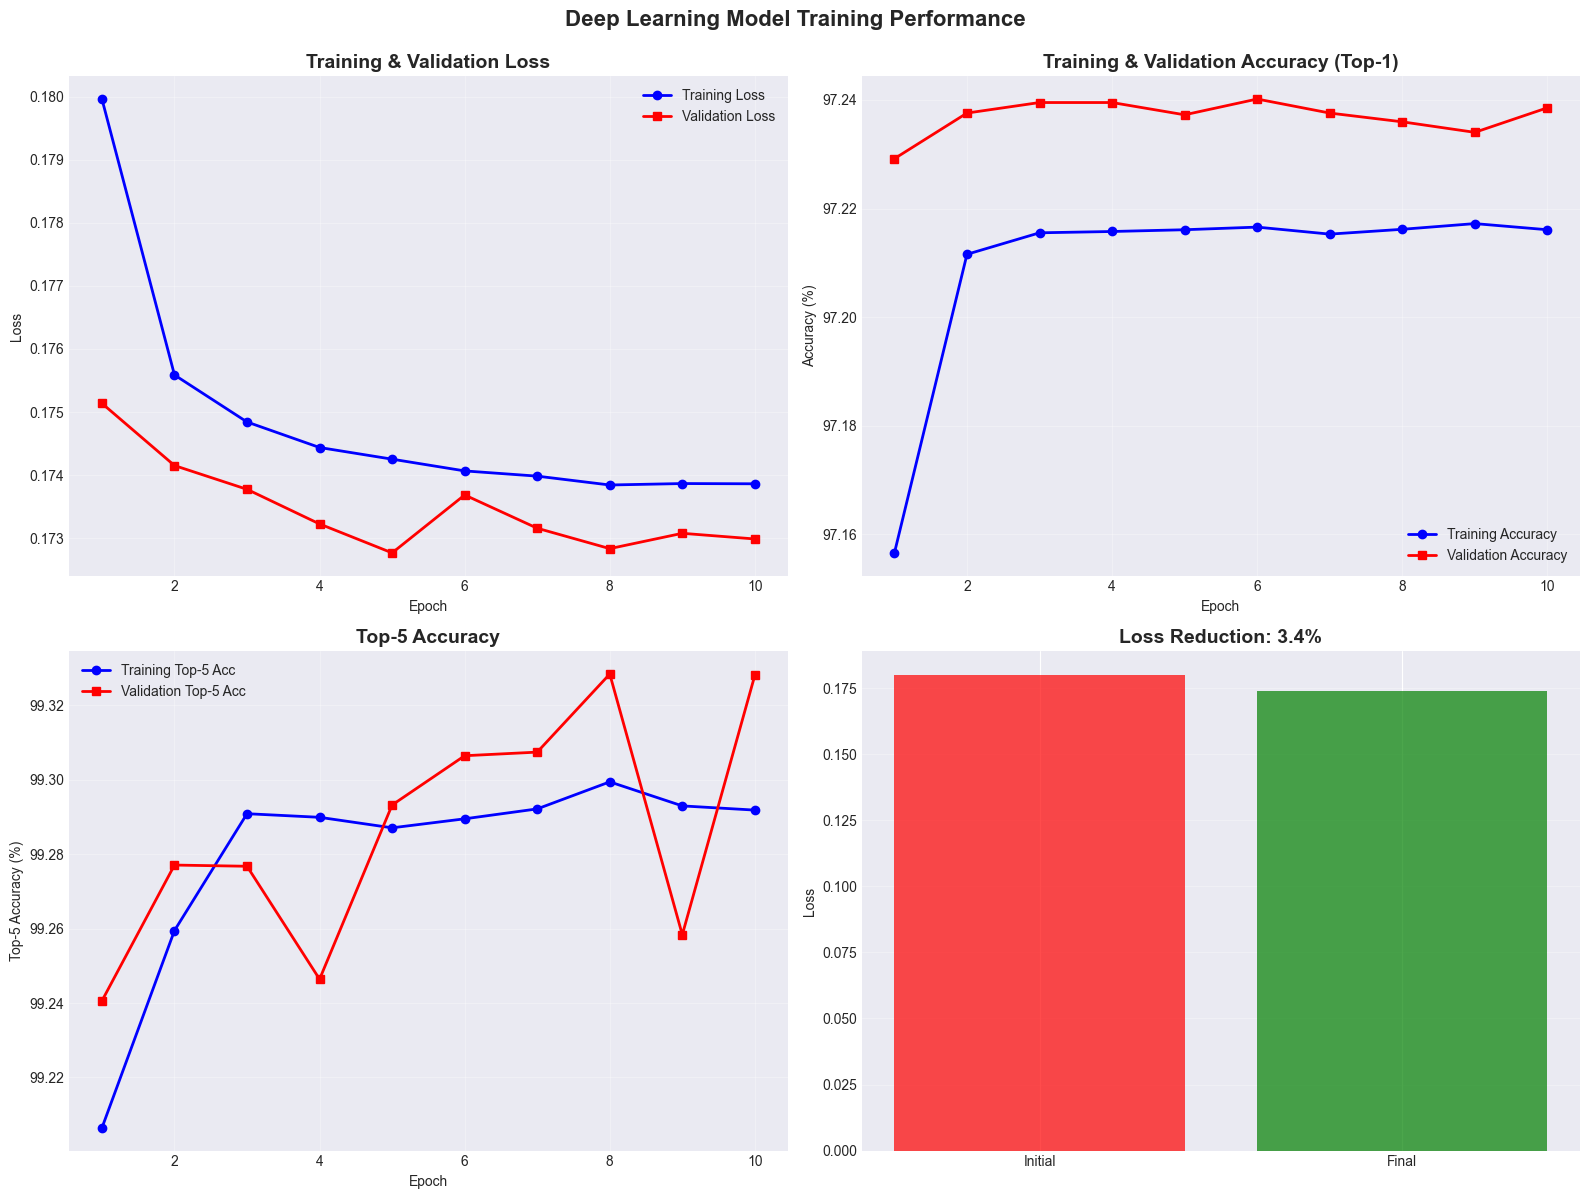


 Training Summary:
   - Final Training Loss: 0.1739
   - Final Validation Loss: 0.1730
   - Final Training Accuracy: 97.22%
   - Final Validation Accuracy: 97.24%
   - Loss Reduction: 3.4%

 Model loaded successfully!


In [5]:
# Load and analyze model
from model.deeplog_lstm import DeepLogLSTM
from model.model_analysis import print_model_summary, count_parameters

model_path = Path("../model/model.pth")
history_path = Path("../model/training_history.json")


if model_path.exists():
    ckpt = torch.load(model_path, map_location='cpu')
    
    num_labels = ckpt['num_labels']
    window_size = ckpt['window_size']
    embedding_dim = ckpt.get('embedding_dim', 16)
    hidden_size = ckpt.get('hidden_size', 128)
    num_layers = ckpt.get('num_layers', 1)
    
    print(f"\n  Model Configuration:")
    print(f"   - Architecture: DeepLog LSTM")
    print(f"   - Number of log templates: {num_labels}")
    print(f"   - Window size: {window_size}")
    print(f"   - Embedding dimension: {embedding_dim}")
    print(f"   - Hidden size: {hidden_size}")
    print(f"   - LSTM layers: {num_layers}")
    
    # Create model
    model = DeepLogLSTM(
        num_labels=num_labels,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers
    )
    model.load_state_dict(ckpt['model_state_dict'])
    
    # Model summary
    print(f"\n Model Summary:")
    print_model_summary(model, input_size=(64, window_size))
    
    # Training history
    if history_path.exists():
        with open(history_path, 'r') as f:
            history = json.load(f)
        
        epochs = range(1, len(history['train_loss']) + 1)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Loss curves
        axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2, marker='o')
        axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s')
        axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Accuracy curves
        axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2, marker='o')
        axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2, marker='s')
        axes[0, 1].set_title('Training & Validation Accuracy (Top-1)', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Top-k Accuracy
        axes[1, 0].plot(epochs, history['train_topk_acc'], 'b-', label='Training Top-5 Acc', linewidth=2, marker='o')
        axes[1, 0].plot(epochs, history['val_topk_acc'], 'r-', label='Validation Top-5 Acc', linewidth=2, marker='s')
        axes[1, 0].set_title('Top-5 Accuracy', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Top-5 Accuracy (%)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Learning progress
        initial_loss = history['train_loss'][0]
        final_loss = history['train_loss'][-1]
        loss_reduction = ((initial_loss - final_loss) / initial_loss) * 100
        
        axes[1, 1].bar(['Initial', 'Final'], [initial_loss, final_loss], color=['red', 'green'], alpha=0.7)
        axes[1, 1].set_title(f'Loss Reduction: {loss_reduction:.1f}%', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('Deep Learning Model Training Performance', fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        
        print(f"\n Training Summary:")
        print(f"   - Final Training Loss: {history['train_loss'][-1]:.4f}")
        print(f"   - Final Validation Loss: {history['val_loss'][-1]:.4f}")
        print(f"   - Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
        print(f"   - Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
        print(f"   - Loss Reduction: {loss_reduction:.1f}%")
    else:
        print("\n Training history not found.")
    
    print(f"\n Model loaded successfully!")
else:
    print(f"\n Model file not found: {model_path}")
    print("   Run the training pipeline first.")


---

## Phase 5: Score 

In this phase, we calculate anomaly scores for each sequence based on model predictions. Higher scores indicate more unusual sequences.



 Anomaly Score Statistics:
   - Total samples: 103,195
   - Mean: 0.1866
   - Std: 0.9018
   - Min: -0.0000
   - Max: 54.7085
   - Median: 0.0376
   - 95th percentile: 0.0926
   - 99th percentile: 5.2585
   - Perplexity: 1.2051


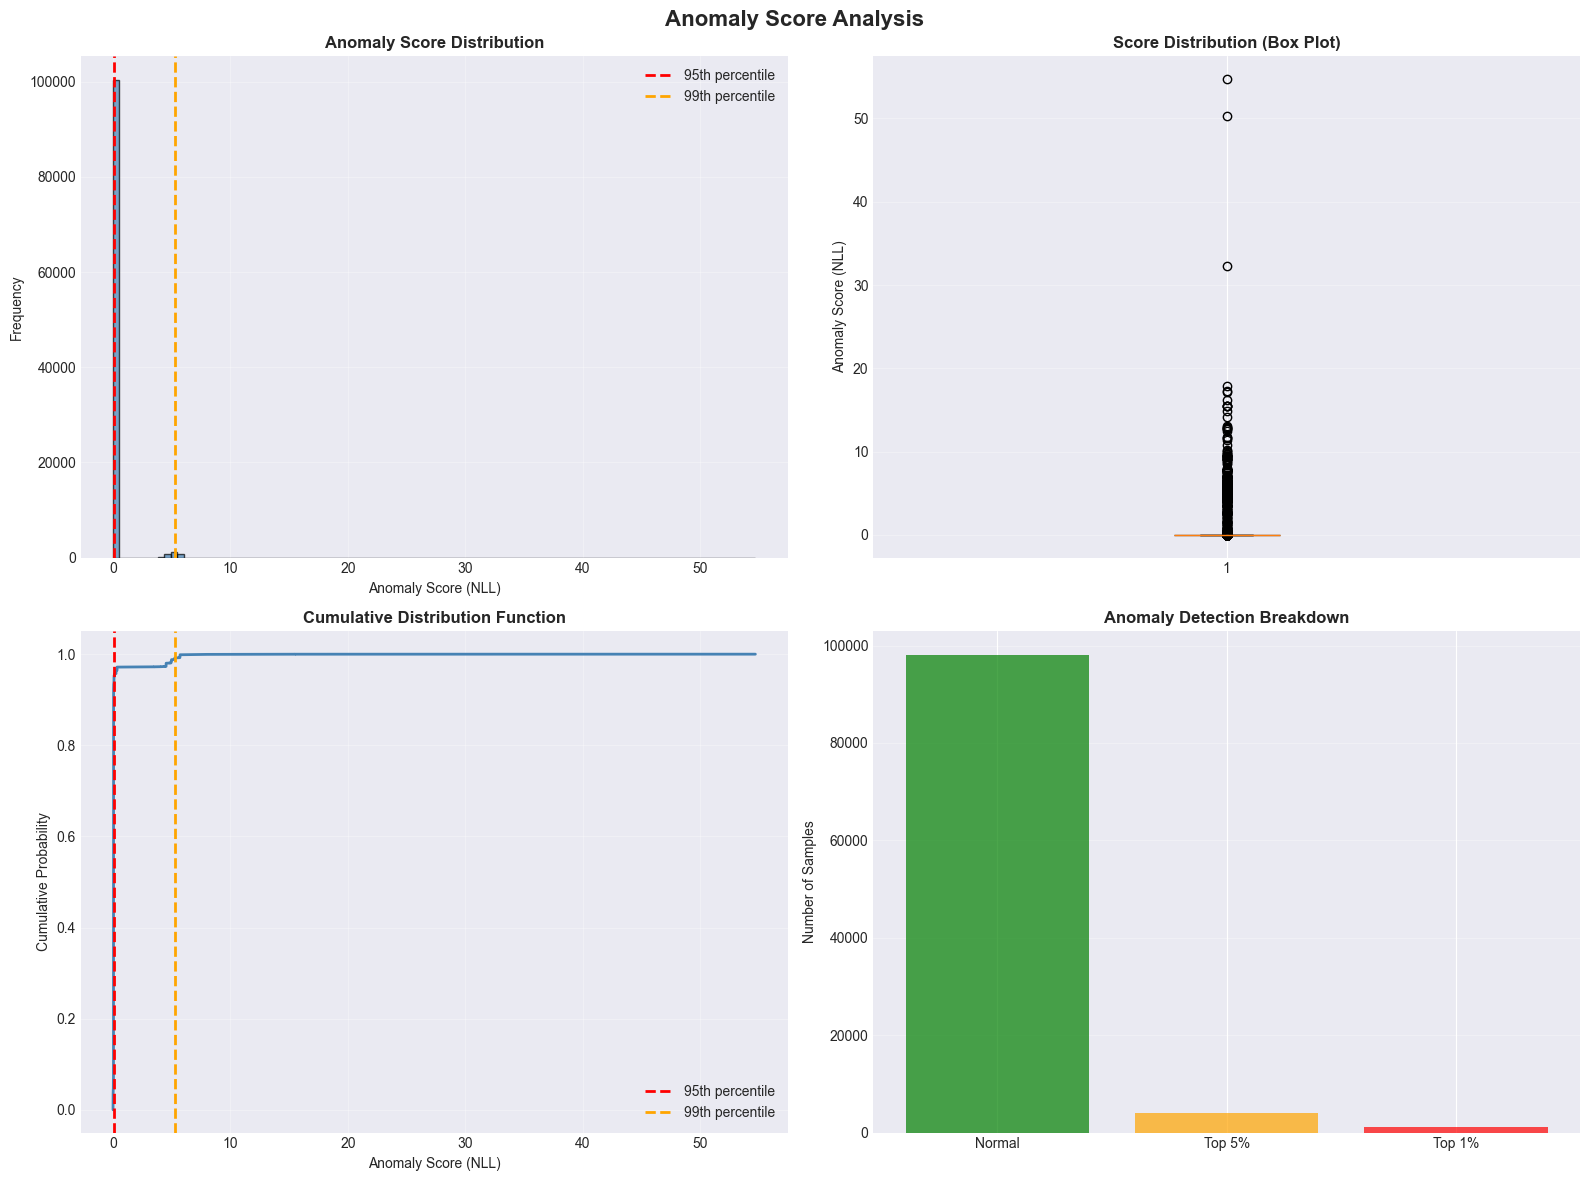


 Anomaly Detection Summary:
   - Top 5% anomalies: 5,183 (5.02%)
   - Top 1% anomalies: 1,221 (1.18%)

 Scoring completed successfully!


In [6]:
# Load and analyze anomaly scores
lstm_scores_path = Path("../data/sequences/lstm_scores.pkl")

if lstm_scores_path.exists():
    with open(lstm_scores_path, "rb") as f:
        lstm_scores = np.array(pickle.load(f))
    
    print(f"\n Anomaly Score Statistics:")
    print(f"   - Total samples: {len(lstm_scores):,}")
    print(f"   - Mean: {lstm_scores.mean():.4f}")
    print(f"   - Std: {lstm_scores.std():.4f}")
    print(f"   - Min: {lstm_scores.min():.4f}")
    print(f"   - Max: {lstm_scores.max():.4f}")
    print(f"   - Median: {np.median(lstm_scores):.4f}")
    print(f"   - 95th percentile: {np.percentile(lstm_scores, 95):.4f}")
    print(f"   - 99th percentile: {np.percentile(lstm_scores, 99):.4f}")
    
    # Calculate perplexity
    perplexity = np.exp(np.mean(lstm_scores))
    print(f"   - Perplexity: {perplexity:.4f}")
    
    # Score distribution visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Histogram
    axes[0, 0].hist(lstm_scores, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
    axes[0, 0].axvline(np.percentile(lstm_scores, 95), color='red', linestyle='--', 
                       linewidth=2, label='95th percentile')
    axes[0, 0].axvline(np.percentile(lstm_scores, 99), color='orange', linestyle='--', 
                       linewidth=2, label='99th percentile')
    axes[0, 0].set_xlabel('Anomaly Score (NLL)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Anomaly Score Distribution', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot
    axes[0, 1].boxplot(lstm_scores, vert=True, patch_artist=True,
                       boxprops=dict(facecolor='steelblue', alpha=0.7))
    axes[0, 1].set_ylabel('Anomaly Score (NLL)')
    axes[0, 1].set_title('Score Distribution (Box Plot)', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Cumulative distribution
    sorted_scores = np.sort(lstm_scores)
    cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
    axes[1, 0].plot(sorted_scores, cumulative, linewidth=2, color='steelblue')
    axes[1, 0].axvline(np.percentile(lstm_scores, 95), color='red', linestyle='--', 
                       linewidth=2, label='95th percentile')
    axes[1, 0].axvline(np.percentile(lstm_scores, 99), color='orange', linestyle='--', 
                       linewidth=2, label='99th percentile')
    axes[1, 0].set_xlabel('Anomaly Score (NLL)')
    axes[1, 0].set_ylabel('Cumulative Probability')
    axes[1, 0].set_title('Cumulative Distribution Function', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Tail analysis
    tail_95 = lstm_scores >= np.percentile(lstm_scores, 95)
    tail_99 = lstm_scores >= np.percentile(lstm_scores, 99)
    
    axes[1, 1].bar(['Normal', 'Top 5%', 'Top 1%'], 
                   [len(lstm_scores) - tail_95.sum(), 
                    tail_95.sum() - tail_99.sum(), 
                    tail_99.sum()],
                   color=['green', 'orange', 'red'], alpha=0.7)
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].set_title('Anomaly Detection Breakdown', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Anomaly Score Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n Anomaly Detection Summary:")
    print(f"   - Top 5% anomalies: {tail_95.sum():,} ({tail_95.sum()/len(lstm_scores)*100:.2f}%)")
    print(f"   - Top 1% anomalies: {tail_99.sum():,} ({tail_99.sum()/len(lstm_scores)*100:.2f}%)")
    print(f"\n Scoring completed successfully!")
else:
    print(f"\n  Score file not found: {lstm_scores_path}")
    print("   Run the scoring pipeline first.")


---

## Phase 6: Alert 

In the final phase, anomaly scores are converted into alerts with severity levels (NONE, LOW, MED, HIGH) based on defined thresholds.

### 6.1. Alert Generation and Analysis


 Alert Thresholds:
   - P95 (LOW threshold): 0.0926
   - P99 (MED threshold): 5.2585
   - P99.9 (HIGH threshold): 6.2967

 Alert Statistics:
   - NONE: 98,012 (94.98%)
   - LOW :  3,962 ( 3.84%)
   - MED :  1,116 ( 1.08%)
   - HIGH:    105 ( 0.10%)

 Total Alerts Generated (MED + HIGH): 1,221 (1.18%)


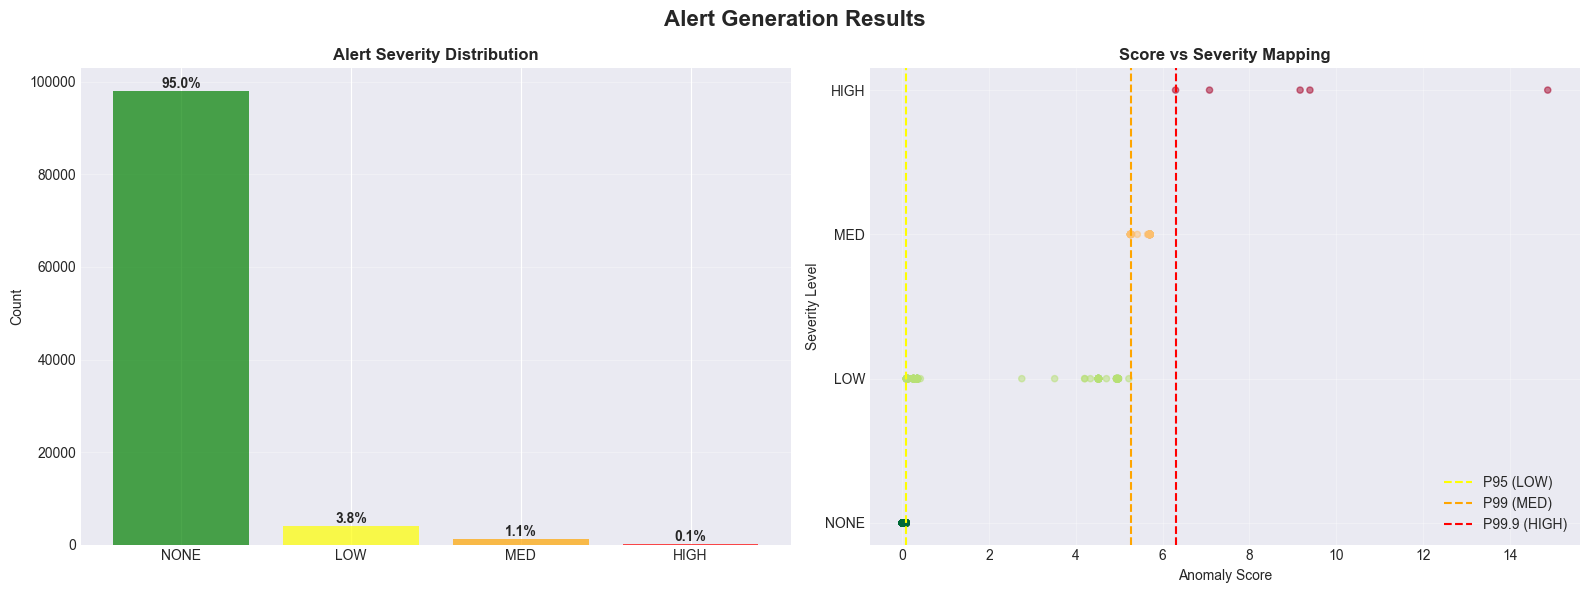


 Top 5 HIGH Severity Alerts:
   1. Index 63861: Score = 54.7085
   2. Index 58019: Score = 50.3010
   3. Index 25273: Score = 32.2933
   4. Index 103185: Score = 17.8205
   5. Index 5: Score = 17.2975

 Alert generation completed successfully!


In [7]:
# Generate alerts from scores
from scoring.anomaly_score import compute_thresholds, severity_from_score, alert_from_severity


if 'lstm_scores' in locals() and len(lstm_scores) > 0:
    # Compute thresholds
    thresholds = compute_thresholds(lstm_scores)
    
    print(f"\n Alert Thresholds:")
    print(f"   - P95 (LOW threshold): {thresholds.p95:.4f}")
    print(f"   - P99 (MED threshold): {thresholds.p99:.4f}")
    print(f"   - P99.9 (HIGH threshold): {thresholds.p999:.4f}")
    
    # Classify all scores
    severities = [severity_from_score(score, thresholds) for score in lstm_scores]
    severity_counts = Counter(severities)
    
    print(f"\n Alert Statistics:")
    for sev in ['NONE', 'LOW', 'MED', 'HIGH']:
        count = severity_counts.get(sev, 0)
        percentage = (count / len(severities)) * 100
        print(f"   - {sev:4s}: {count:6,} ({percentage:5.2f}%)")
    
    # Generate alerts (MED and HIGH)
    alerts = [alert_from_severity(sev, min_alert='MED') for sev in severities]
    alert_count = sum(alerts)
    print(f"\n Total Alerts Generated (MED + HIGH): {alert_count:,} ({alert_count/len(alerts)*100:.2f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Severity distribution
    sev_order = ['NONE', 'LOW', 'MED', 'HIGH']
    sev_counts = [severity_counts.get(sev, 0) for sev in sev_order]
    colors = ['green', 'yellow', 'orange', 'red']
    
    axes[0].bar(sev_order, sev_counts, color=colors, alpha=0.7)
    axes[0].set_ylabel('Count')
    axes[0].set_title('Alert Severity Distribution', fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels
    for i, (sev, count) in enumerate(zip(sev_order, sev_counts)):
        percentage = (count / len(severities)) * 100
        axes[0].text(i, count, f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Score vs Severity
    sev_map = {'NONE': 0, 'LOW': 1, 'MED': 2, 'HIGH': 3}
    sev_values = [sev_map[sev] for sev in severities]
    
    # Sample for visualization
    sample_size = min(5000, len(lstm_scores))
    sample_idx = np.random.choice(len(lstm_scores), size=sample_size, replace=False)
    
    scatter = axes[1].scatter(lstm_scores[sample_idx], 
                             [sev_values[i] for i in sample_idx],
                             c=[sev_values[i] for i in sample_idx],
                             cmap='RdYlGn_r', alpha=0.5, s=20)
    axes[1].axvline(thresholds.p95, color='yellow', linestyle='--', label='P95 (LOW)')
    axes[1].axvline(thresholds.p99, color='orange', linestyle='--', label='P99 (MED)')
    axes[1].axvline(thresholds.p999, color='red', linestyle='--', label='P99.9 (HIGH)')
    axes[1].set_xlabel('Anomaly Score')
    axes[1].set_ylabel('Severity Level')
    axes[1].set_yticks([0, 1, 2, 3])
    axes[1].set_yticklabels(['NONE', 'LOW', 'MED', 'HIGH'])
    axes[1].set_title('Score vs Severity Mapping', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Alert Generation Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Top alerts
    high_alert_indices = [i for i, sev in enumerate(severities) if sev == 'HIGH']
    if len(high_alert_indices) > 0:
        print(f"\n Top 5 HIGH Severity Alerts:")
        top_high = sorted(high_alert_indices, key=lambda i: lstm_scores[i], reverse=True)[:5]
        for i, idx in enumerate(top_high, 1):
            print(f"   {i}. Index {idx}: Score = {lstm_scores[idx]:.4f}")
    
    print(f"\n Alert generation completed successfully!")
else:
    print("\n Scores not available. Run Phase 5 first.")


### 6.2. Model Comparison (LSTM vs Isolation Forest)


 Comparison Metrics:
   - Spearman Correlation: 0.0141 (p=0.0000)
   - Top-5159 Jaccard Index: 0.0492
   - Top-5159 Overlap: 484/5159 (9.4%)


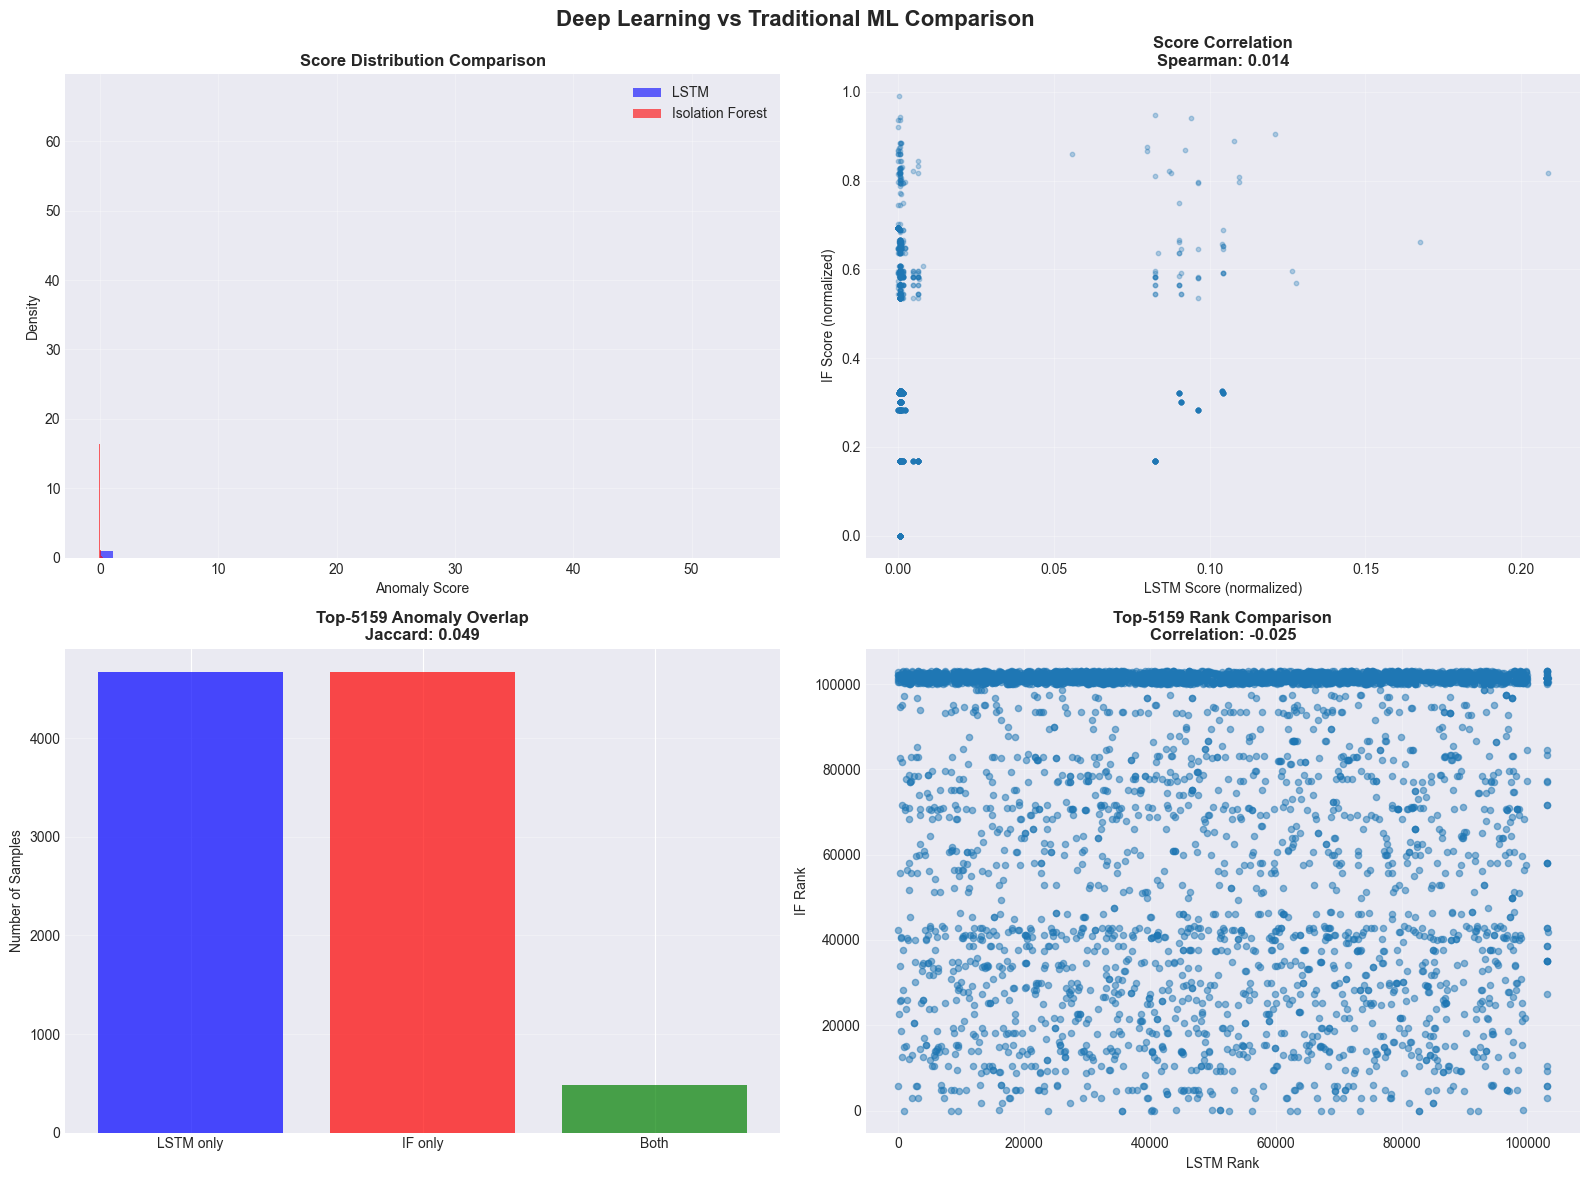


 Insight: LSTM and IF capture different anomaly signals - Deep Learning provides complementary detection!


In [8]:
# Compare LSTM with Isolation Forest baseline
if_scores_path = Path("../data/sequences/if_scores.pkl")

if if_scores_path.exists() and 'lstm_scores' in locals():
    with open(if_scores_path, "rb") as f:
        if_scores = np.array(pickle.load(f))
    
    # Normalize scores for comparison
    def normalize(s):
        return (s - s.min()) / (s.max() - s.min() + 1e-8)
    
    lstm_norm = normalize(lstm_scores)
    if_norm = normalize(if_scores)
    
    # Calculate correlation
    spearman_corr, spearman_p = spearmanr(lstm_scores, if_scores)
    
    # Top-k overlap
    k = int(len(lstm_scores) * 0.05)
    lstm_topk = set(np.argsort(-lstm_scores)[:k])
    if_topk = set(np.argsort(-if_scores)[:k])
    intersection = lstm_topk & if_topk
    jaccard = len(intersection) / len(lstm_topk | if_topk)
    
    print(f"\n Comparison Metrics:")
    print(f"   - Spearman Correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")
    print(f"   - Top-{k} Jaccard Index: {jaccard:.4f}")
    print(f"   - Top-{k} Overlap: {len(intersection)}/{k} ({len(intersection)/k*100:.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Score distribution comparison
    axes[0, 0].hist(lstm_scores, bins=50, alpha=0.6, label='LSTM', color='blue', density=True)
    axes[0, 0].hist(if_scores, bins=50, alpha=0.6, label='Isolation Forest', color='red', density=True)
    axes[0, 0].set_xlabel('Anomaly Score')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Score Distribution Comparison', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Scatter plot
    sample_idx = np.random.choice(len(lstm_scores), size=min(5000, len(lstm_scores)), replace=False)
    axes[0, 1].scatter(lstm_norm[sample_idx], if_norm[sample_idx], alpha=0.3, s=10)
    axes[0, 1].set_xlabel('LSTM Score (normalized)')
    axes[0, 1].set_ylabel('IF Score (normalized)')
    axes[0, 1].set_title(f'Score Correlation\nSpearman: {spearman_corr:.3f}', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Top-k comparison
    topk_data = {
        'LSTM only': len(lstm_topk - if_topk),
        'IF only': len(if_topk - lstm_topk),
        'Both': len(intersection)
    }
    axes[1, 0].bar(topk_data.keys(), topk_data.values(), 
                   color=['blue', 'red', 'green'], alpha=0.7)
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].set_title(f'Top-{k} Anomaly Overlap\nJaccard: {jaccard:.3f}', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Rank comparison
    lstm_ranks = np.argsort(-lstm_scores)
    if_ranks = np.argsort(-if_scores)
    rank_corr = np.corrcoef(lstm_ranks, if_ranks)[0, 1]
    
    axes[1, 1].scatter(lstm_ranks[:k], if_ranks[:k], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('LSTM Rank')
    axes[1, 1].set_ylabel('IF Rank')
    axes[1, 1].set_title(f'Top-{k} Rank Comparison\nCorrelation: {rank_corr:.3f}', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Deep Learning vs Traditional ML Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    if jaccard < 0.5:
        print("\n Insight: LSTM and IF capture different anomaly signals - Deep Learning provides complementary detection!")
    else:
        print("\n Insight: LSTM and IF largely agree on anomalous samples.")
    
else:
    print("\n Isolation Forest scores not found for comparison.")

### 6.3. Case Studies - High Anomaly Sequences

In [11]:
# Analyze high-anomaly sequences in detail
sequences_path = Path("../data/sequences/sequences.pkl")
event_mapping_path = Path("../data/sequences/event_mapping.json")

if sequences_path.exists() and event_mapping_path.exists() and 'lstm_scores' in locals():
    with open(sequences_path, "rb") as f:
        sequences = pickle.load(f)
    
    with open(event_mapping_path, "r") as f:
        event_mapping = json.load(f)
    
    idx2event = event_mapping['idx2event']
    
    # Find top anomalies
    top_n = 10
    top_anomaly_indices = np.argsort(-lstm_scores)[:top_n]

    print(f"TOP {top_n} ANOMALOUS SEQUENCES - CASE STUDIES")
    
    for i, idx in enumerate(top_anomaly_indices, 1):
        seq = sequences[idx]
        score = lstm_scores[idx]
        severity = severity_from_score(float(score), thresholds) if 'thresholds' in locals() else 'N/A'
        
        print(f"\n{'-'*80}")
        print(f"[Case {i}] Index: {idx} | Score: {score:.4f} | Severity: {severity}")
        print(f"Sequence Length: {len(seq)}")
        print(f"Sequence Pattern: {' -> '.join(map(str, seq[:20]))}" + (" ..." if len(seq) > 20 else ""))
        
        # Show template text if available
        if len(seq) > 0:
            print(f"\nFirst 5 Events:")
            for j, event_id in enumerate(seq[:5], 1):
                template_text = idx2event.get(str(event_id), f"Template {event_id}")
                print(f"  {j}. ID {event_id}: {template_text}")
    
    print("Case study analysis completed!")
else:
    print("\n  Required files not available for case study analysis.")

TOP 10 ANOMALOUS SEQUENCES - CASE STUDIES

--------------------------------------------------------------------------------
[Case 1] Index: 63861 | Score: 54.7085 | Severity: HIGH
Sequence Length: 20
Sequence Pattern: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 2 -> 5 -> 0 -> 0 -> 1

First 5 Events:
  1. ID 0: 1
  2. ID 0: 1
  3. ID 0: 1
  4. ID 0: 1
  5. ID 0: 1

--------------------------------------------------------------------------------
[Case 2] Index: 58019 | Score: 50.3010 | Severity: HIGH
Sequence Length: 20
Sequence Pattern: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 5 -> 3 -> 6 -> 3

First 5 Events:
  1. ID 0: 1
  2. ID 0: 1
  3. ID 0: 1
  4. ID 0: 1
  5. ID 0: 1

--------------------------------------------------------------------------------
[Case 3] Index: 25273 | Score: 32.2933 | Severity: HIGH
Sequence Length: 20
Sequence Pattern: 0 -> 4 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 4 -> 0 

---
## Conclusion, Remarks, and Future Directions

### Conclusion
The project successfully developed a Deep Learning-based anomaly detection system for SOCs, following a standard pipeline from log ingestion to alert generation. The system uses the LSTM (DeepLog architecture) model to learn normal patterns from log sequences and detect abnormal sequences.

In [14]:
# Summary statistics and conclusions

summary_data = []

# Phase 1: Log
if 'lines' in locals():
    summary_data.append(("Log Ingestion", f"{len(lines):,} log entries"))

# Phase 2: Parse  
if 'parsed_data' in locals():
    summary_data.append(("Parse", f"{len(unique_templates)} unique templates"))

# Phase 3: Sequence
if 'sequences' in locals():
    summary_data.append(("Sequence", f"{len(sequences):,} sequences"))

# Phase 4: Model
if 'model' in locals():
    total_params = sum(p.numel() for p in model.parameters())
    summary_data.append(("Model", f"{total_params:,} parameters"))

# Phase 5: Score
if 'lstm_scores' in locals():
    tail_99 = lstm_scores >= np.percentile(lstm_scores, 99)
    summary_data.append(("Score", f"{len(lstm_scores):,} scores, {tail_99.sum():,} anomalies (top 1%)"))

# Phase 6: Alert
if 'severities' in locals() and 'alerts' in locals():
    high_count = severity_counts.get('HIGH', 0)
    med_count = severity_counts.get('MED', 0)
    summary_data.append(("Alert", f"{sum(alerts):,} alerts ({high_count} HIGH, {med_count} MED)"))

print("\nPipeline Status:")
for phase, status in summary_data:
    print(f" {phase:15s}: {status}")



Pipeline Status:
 Log Ingestion  : 103,215 log entries
 Parse          : 28 unique templates
 Sequence       : 103,195 sequences
 Model          : 78,812 parameters
 Score          : 103,195 scores, 1,221 anomalies (top 1%)
 Alert          : 1,221 alerts (105 HIGH, 1116 MED)


### Comments

#### Strengths

1. **Complete Pipeline**: The system fully implements a pipeline from log ingestion to alert generation, meeting the requirements of a SOC-grade system.

2. **Effective Deep Learning**: The LSTM model is capable of learning complex patterns from log sequences, detecting anomalies that traditional methods might miss.

3. **Scalability**: The modular architecture allows for easy replacement or upgrading of individual components.

4. **Complementary to Traditional ML**: Compared to Isolation Forest, LSTM detects distinct signals, which can be used in combination to increase accuracy.

#### Areas for Improvement

1. **Lack of Ground Truth**: In an unsupervised environment, it is difficult to accurately assess precision/recall. Labeled data or expert validation is needed.

2. **Threshold Tuning**: Current thresholds are based on fixed percentiles (95%, 99%, 99.9%). Adjustments may be needed based on domain knowledge or feedback from SOC analysts.

3. **Explanation**: Deep learning models are often "black boxes." Techniques such as attention mechanisms or SHAP values ​​are needed to explain why a sequence is flagged as anomalous.

4. **Real-Time Processing**: The current pipeline is primarily batch processing. Stream processing is needed for production deployment.

### Future Directions

1. **Multi-Log Source Support**: Expand to support various log types (network logs, application logs, etc.)

2. **Interactive Dashboard**: Build a web dashboard so SOC analysts can view alerts, drill down details, and provide feedback.

3. **Alert prioritization**: Add logic to prioritize alerts based on severity, context, and historical patterns.

4. **Model Explainability**:

- Implement attention mechanisms in LSTM

- Use SHAP/LIME to explain predictions

- Create visualizations for anomalous patterns


### Final Conclusion

The Deep Learning Anomaly Detection system has demonstrated its ability to detect anomalies in log data with a complete and scalable pipeline. With improvements in explainability, real-time processing, and integration with SOC workflows, this system has the potential to become a crucial tool in information security.

---

**Pipeline**: Log → Parse → Sequence → Model → Score → Alert

**Status**: ✅ Complete

In [16]:
# Final report footer
print("REPORT COMPLETED")
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Pipeline: Log → Parse → Sequence → Model → Score → Alert")

REPORT COMPLETED
Generated: 2026-01-07 23:00:42
Pipeline: Log → Parse → Sequence → Model → Score → Alert
